# Классификация с помощью kNN. Кластеризация K-means

In [1]:
import numpy as np
from sklearn import model_selection
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
X, y = load_iris(return_X_y=True)

# Для наглядности возьмем только первые два признака (всего в датасете их 4)
X = X[:, :2]

In [3]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)

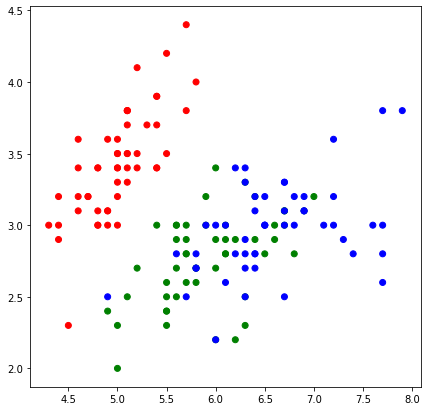

In [4]:
cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap);

In [5]:
def e_metrics(x1, x2):
    
    distance = 0
    for i in range(len(x1)):
        distance += np.square(x1[i] - x2[i])
    
    return np.sqrt(distance)

**1). К алгоритму kNN, реализованному на уроке, реализовать добавление весов соседей по любому из показанных на уроке принципов.**

Добавлена функция веса от расстояния - $0.5^{d}$.

In [6]:
def knn(x_train, y_train, x_test, k, weighted=True):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        for d in sorted(test_distances)[0:k]:
            if weighted:
                classes[d[1]] += 0.5 ** d[1]
            else:
                classes[d[1]] += 1
            
        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
    return answers

In [7]:
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

Проверим работу алгоритма при различных k

In [8]:
k = 3

y_pred = knn(X_train, y_train, X_test, k)
y_pred_weighted = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')
print(f'Точность алгоритма при k = {k} (взвеш.): {accuracy(y_pred_weighted, y_test):.3f}')

Точность алгоритма при k = 3: 0.733
Точность алгоритма при k = 3 (взвеш.): 0.733


Построим график распределения классов.

In [9]:
def get_graph(X_train, y_train, k, weighted=False):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])

    h = .02

    # Расчет пределов графика
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Получим предсказания для всех точек
    Z = knn(X_train, y_train, np.c_[xx.ravel(), yy.ravel()], k, weighted)

    # Построим график
    Z = np.array(Z).reshape(xx.shape)
    plt.figure(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Добавим на график обучающую выборку
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"Трехклассовая kNN классификация при k = {k}")
    plt.show()

Без взвешивания:


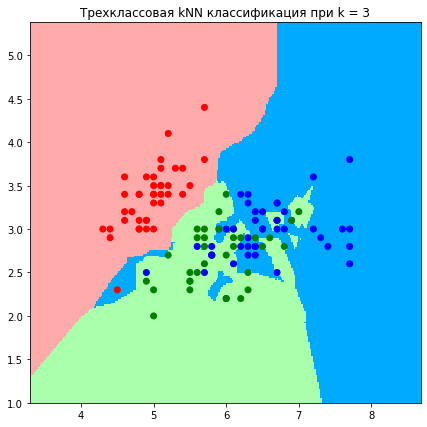

Со взвешиванием:


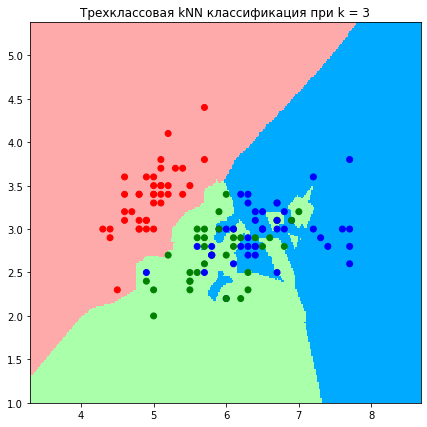

In [10]:
print('Без взвешивания:')
get_graph(X_train, y_train, k)
print('Со взвешиванием:')
get_graph(X_train, y_train, k, weighted=True)

In [11]:
k = 5

y_pred = knn(X_train, y_train, X_test, k)
y_pred_weighted = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')
print(f'Точность алгоритма при k = {k} (взвеш.): {accuracy(y_pred_weighted, y_test):.3f}')

Точность алгоритма при k = 5: 0.733
Точность алгоритма при k = 5 (взвеш.): 0.733


Без взвешивания:


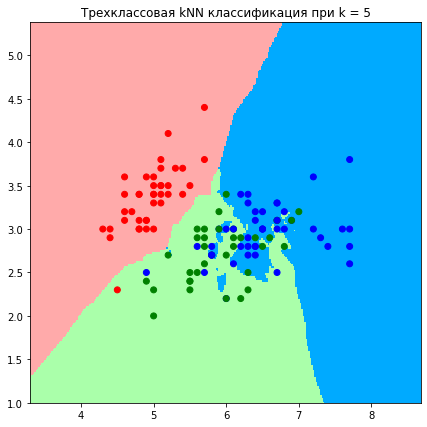

Со взвешиванием:


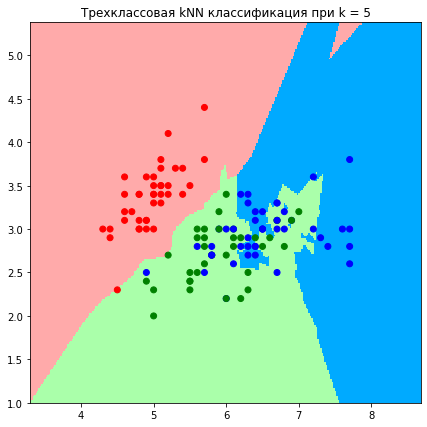

In [12]:
print('Без взвешивания:')
get_graph(X_train, y_train, k)
print('Со взвешиванием:')
get_graph(X_train, y_train, k, weighted=True)

In [13]:
k = 10

y_pred = knn(X_train, y_train, X_test, k)
y_pred_weighted = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')
print(f'Точность алгоритма при k = {k} (взвеш.): {accuracy(y_pred_weighted, y_test):.3f}')

Точность алгоритма при k = 10: 0.867
Точность алгоритма при k = 10 (взвеш.): 0.867


Без взвешивания:


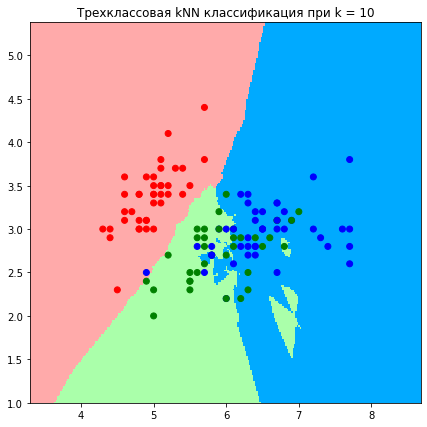

Со взвешиванием:


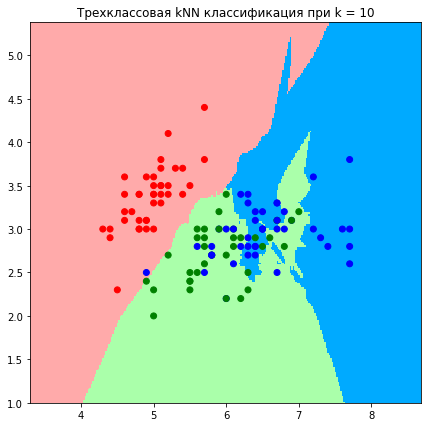

In [14]:
print('Без взвешивания:')
get_graph(X_train, y_train, k)
print('Со взвешиванием:')
get_graph(X_train, y_train, k, weighted=True)

## Обучение без учителя. Кластеризация. K-means

In [15]:
import pandas as pd
import random
from collections import OrderedDict
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=100, random_state=1)

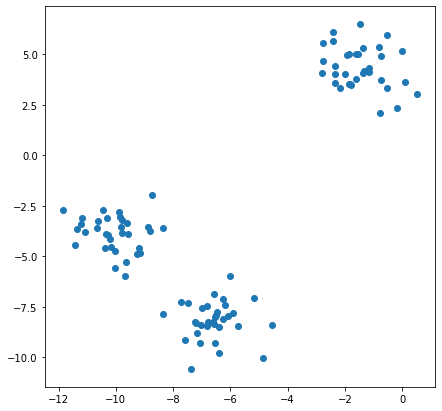

In [16]:
plt.figure(figsize=(7,7))
plt.scatter(X[:, 0], X[:, 1]);

In [17]:
def kmeans(data, k, max_iterations, min_distance):
    # Создадим словарь для классификации
    classes = OrderedDict({i: [] for i in range(k)})
    
    # инициализируем центроиды как первые k элементов датасета
    centroids = [data[i] for i in range(k)]
    
    for _ in range(max_iterations):
        # классифицируем объекты по центроидам
        for x in data:
            # определим расстояния от объекта до каждого центроида
            distances = [e_metrics(x, centroid) for centroid in centroids]
            # отнесем объект к классу, до центроида которого наименьшее расстояние
            classification = distances.index(min(distances))
            classes[classification].append(x)
        
        # сохраним предыдущие центроиды в отдельный список для последующего сравнения сновыми
        old_centroids = centroids.copy()
        
        # пересчитаем центроиды как среднее по кластерам
        for classification in classes:
            centroids[classification] = np.average(classes[classification], axis=0)
            
        # сравним величину смещения центроидов с минимальной
        optimal = True
        for centroid in range(len(centroids)):
            if abs(np.sum((centroids[centroid] - old_centroids[centroid]) / old_centroids * 100)) > min_distance:
                optimal = False
                
        # если все смещения меньше минимального, останавливаем алгоритм  
        if optimal:
            break
    
    return old_centroids, classes

In [18]:
def visualize(centroids, classes):
    colors = ['blue', 'orange', 'green', 'red', 'purple',
              'brown', 'pink', 'gray', 'olive', 'cyan']
    
    plt.figure(figsize=(7,7))
    
    # нанесем на график центроиды
    for centroid in centroids:
        plt.scatter(centroid[0], centroid[1], marker='x', s=130, c='black')
        
    # нанесем объекты раскрашенные по классам
    for class_item in classes:
        for x in classes[class_item]:
            plt.scatter(x[0], x[1], color=colors[class_item])
            
    plt.show()

In [19]:
# определим максимальное количество итераций
max_iterations = 1

# и минимальное расстояние между центроидами до пересчета и после него, при котором нужно остановить алгоритм
min_distance = 1e-4

# сразу определим известное нам количество кластеров
k = 3

Проверим результат алгоритма после одной итерации

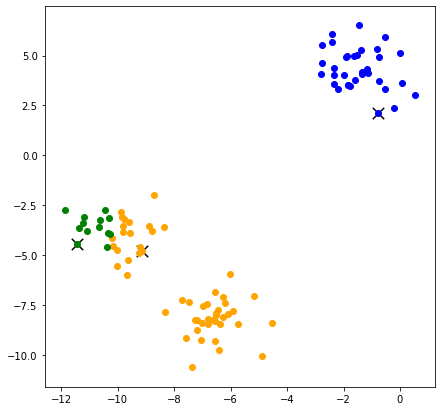

In [20]:
centroids, clusters = kmeans(X, k, max_iterations, min_distance)

visualize(centroids, clusters)

Проверим работу алгоритма при различном числе итераций.

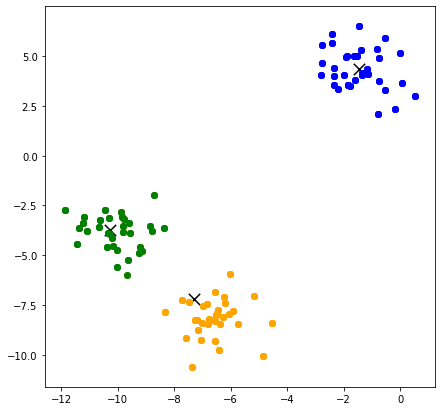

In [21]:
max_iterations = 3

centroids, clusters = kmeans(X, k, max_iterations, min_distance)

visualize(centroids, clusters)

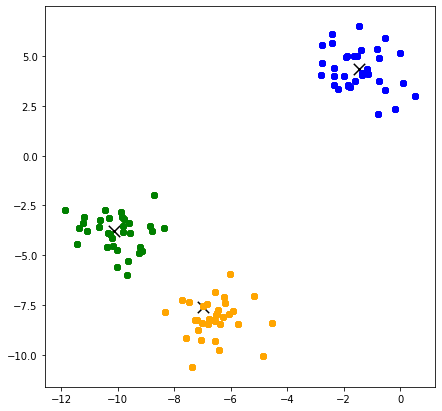

In [22]:
max_iterations = 5

centroids, clusters = kmeans(X, k, max_iterations, min_distance)

visualize(centroids, clusters)

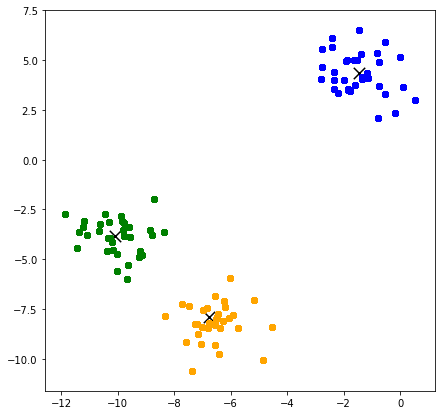

In [23]:
max_iterations = 10

centroids, clusters = kmeans(X, k, max_iterations, min_distance)

visualize(centroids, clusters)

**2). Написать функцию подсчета метрики качества кластеризации как среднее квадратичное внутриклассовое расстояние и построить график ее зависимости от k (взять от 1 до 10) для выборки данных из данного урока.**

In [24]:
def mean_squared_intracluster_distance(cluster, centroid, dim=2):
    cluster_array = np.array(cluster).reshape(-1, dim)
    return np.mean((cluster_array - centroid) ** 2)


k = 1


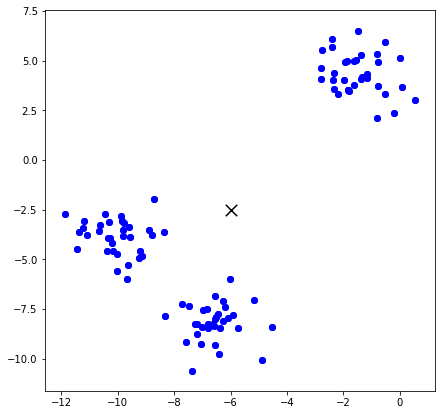


k = 2


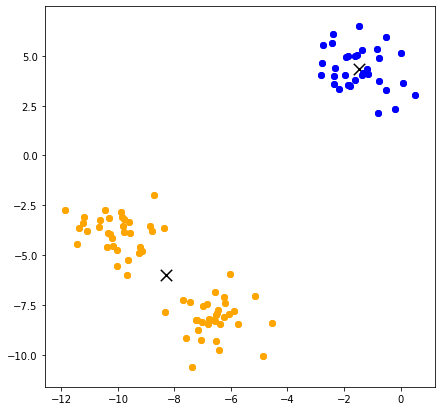


k = 3


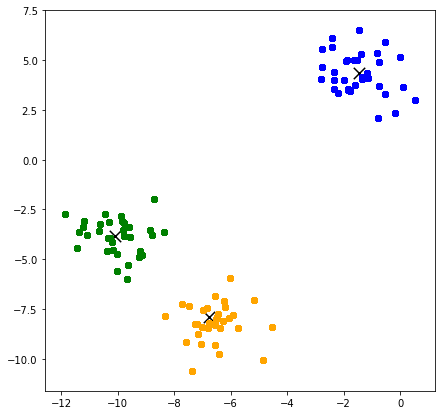


k = 4


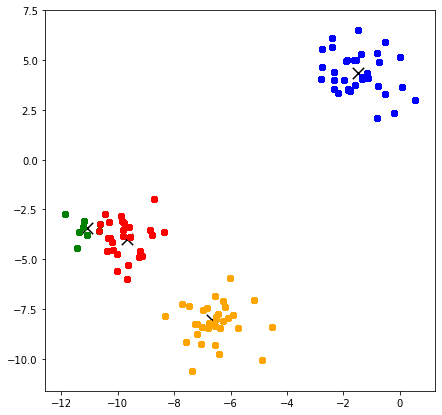


k = 5


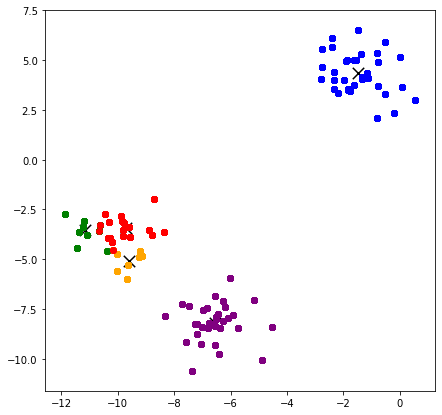


k = 6


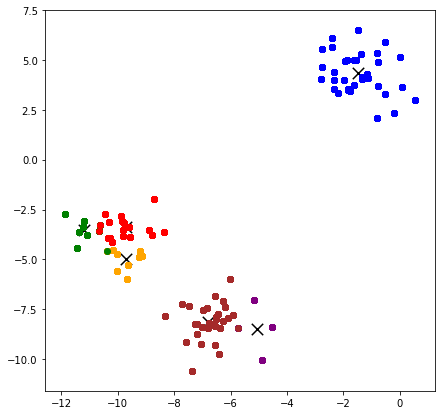


k = 7


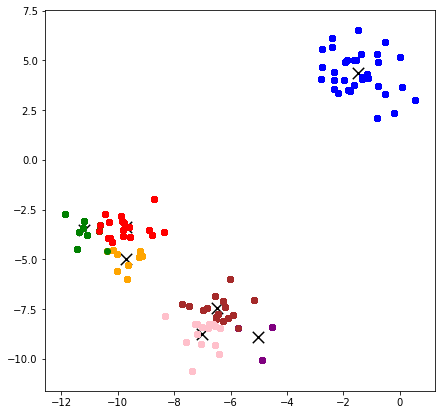


k = 8


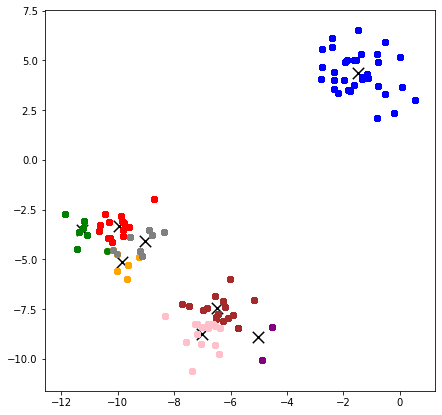


k = 9


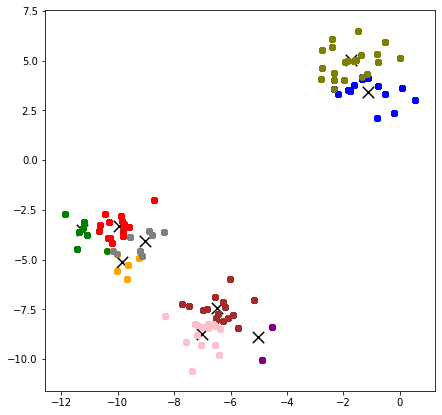


k = 10


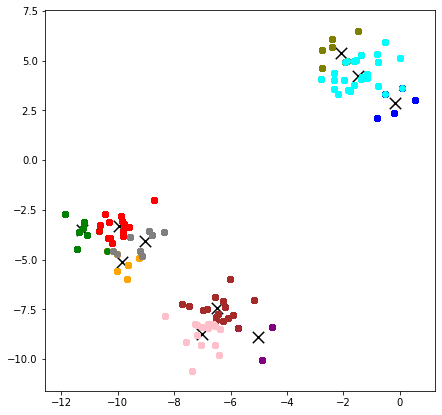

In [25]:
ks = range(1, 11)

all_distances = []
for k in ks:
    centroids, clusters = kmeans(X, k, max_iterations=10, min_distance=1e-6)
    print(f'\nk = {k}')
    visualize(centroids, clusters)
    distances = []
    for i in range(k):
        distance = mean_squared_intracluster_distance(clusters[i], centroids[i])
        distances.append(distance)
    all_distances.append(distances)
    
all_distances = pd.Series(all_distances, index=ks)

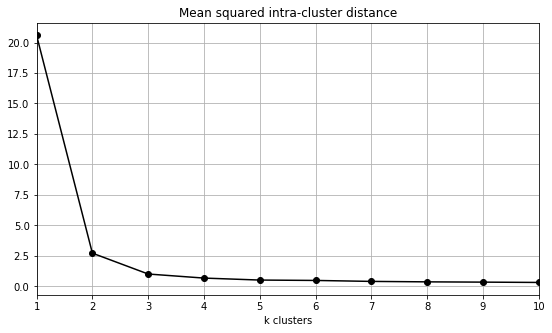

In [26]:
plt.figure(figsize=(9, 5))

all_distances.apply(np.mean).plot(c='k', marker='o')

plt.title('Mean squared intra-cluster distance')
plt.xlabel('k clusters')
plt.grid(True)
plt.show()

Как видно из графика, после достижения оптимального количества кластеров ($k=3$) внутрикластерное расстояние в данном случае реального расположения кластеров устанавливается и сильно не меняется, и поэтому увеличивать его смысла нет.